# Projet "Capitals Learning"
## Classification d'images de capitales du monde

Groupe : Paul ANACLET, Nicolas CORMARY, Sylvain CROUZET, Théo DESPRATS

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from models.basic_model_1 import basic_model_1
from models.vgg16_model import vgg16_model
from features.load_data import load_data
from features.get_classes import get_classes
from data.dispatch_data import dispatch_data
from visualization.plot_classes_repartition import plot_classes_repartition
from visualization.plot_training_analysis import plot_training_analysis
from visualization.visualize_random_images import visualize_random_images

### Meta-paramètres

In [2]:
EPOCHS = 50
BATCH_SIZE = 10
LEARNING_RATE = 3e-4
class_labels = ["NY", "Paris", "Tokyo"]

### Meta-fonctions

In [48]:
#Calcule la précision, le rappel, et le F1_score pour chaque classe ainsi que la matrice de confusion
def global_accuracy(y_true, y_pred):
    class_metrics = []
    for i in range(3):
        class_metrics.append({'TP': 0, 'FP': 0, 'FN': 0})

    total_correct_detections = 0
    total_incorrect_detections = 0
    for i in range(len(y_true)):
        # Labels vérité-terrain et prédits        
        groundtruth_label = int(y_true[i])
        predicted_label = np.argmax(y_pred[i])

        # Si la détection est correcte : 
        if groundtruth_label == predicted_label:
            total_correct_detections += 1
            class_metrics[groundtruth_label]['TP'] += 1 
        else:
            total_incorrect_detections += 1
            class_metrics[groundtruth_label]['FN'] += 1 
            class_metrics[predicted_label]['FP'] += 1


    class_res = []
    print("Matrice de confusion")
    for i in range(3):
        TP = class_metrics[i]['TP']
        FN = class_metrics[i]['FN']
        FP = class_metrics[i]['FP']
        print(class_labels[i],":   TP:",TP," FN:",FN, " FP:",FP)

        if TP != 0:
            P = TP / (TP + FP)
            R = TP / (TP + FN)
            F_score = 2 / (1/R + 1/P)
        else:
            P = 0
            R = 0
            F_score = 0
        class_res.append({'Precision': P, 'Rappel': R, 'F-score': F_score})

    accuracy = total_correct_detections / (total_correct_detections + total_incorrect_detections)

    ### FIN
    return class_res, accuracy

In [49]:
def show_prediction(x, y, y_pred=[], id=None, image_size=64):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = int(y[num_img])
  lab_pred = np.argmax(y_pred[num_img])

  # Affichage de l'image
  plt.title("Prédiction: {} - Réel: {}".format(class_labels[lab_pred], class_labels[lab]))
  plt.imshow(img)
  plt.show()

In [ ]:
def show_analye(x_test, y_test):
    y_pred = model.predict(x_test)

    class_res, accuracy = global_accuracy(y_test, y_pred)

    print(f"La précision globale est de {accuracy:.1f}%")

    print()
    print("------------------------------------------")
    print("| Classe | Précision | Rappel | F1-score |")
    print("------------------------------------------")
    for i in range(3):
        print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
        print("------------------------------------------")
    
    image_idx = [1,18,67,98,145,187,121]

    for i in image_idx:
        show_prediction(x_test, y_test, y_pred = y_pred, id=i, image_size=IMAGE_SIZE)

## Chargement des données

### Répartition des images

In [3]:
# Répartition des images dans les différents datasets
pourcentageTrain = 70
pourcentageTest = 15
pourcentageValidation = 15

dispatch_data(pourcentageTrain, pourcentageTest, pourcentageValidation)


Images successfully dispatched.


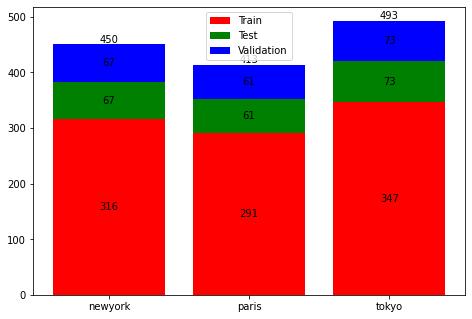

In [4]:
plot_classes_repartition()

### Chargement des images

In [3]:
CLASSES = get_classes()
IMAGE_SIZE = 64

x_train, y_train = load_data(dataset='train', image_size=IMAGE_SIZE)
x_val, y_val = load_data(dataset='validation', image_size=IMAGE_SIZE)
x_test, y_test = load_data(dataset='test', image_size=IMAGE_SIZE)


# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Visualisation des images

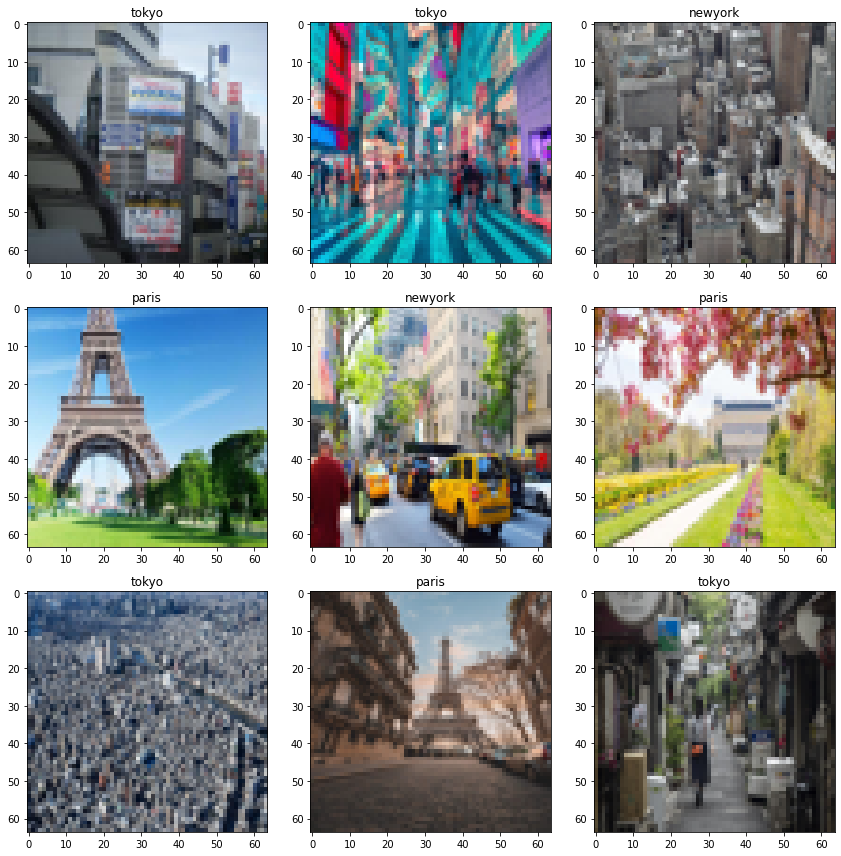

In [4]:
%matplotlib inline

visualize_random_images(x_train, y_train, CLASSES)

### Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

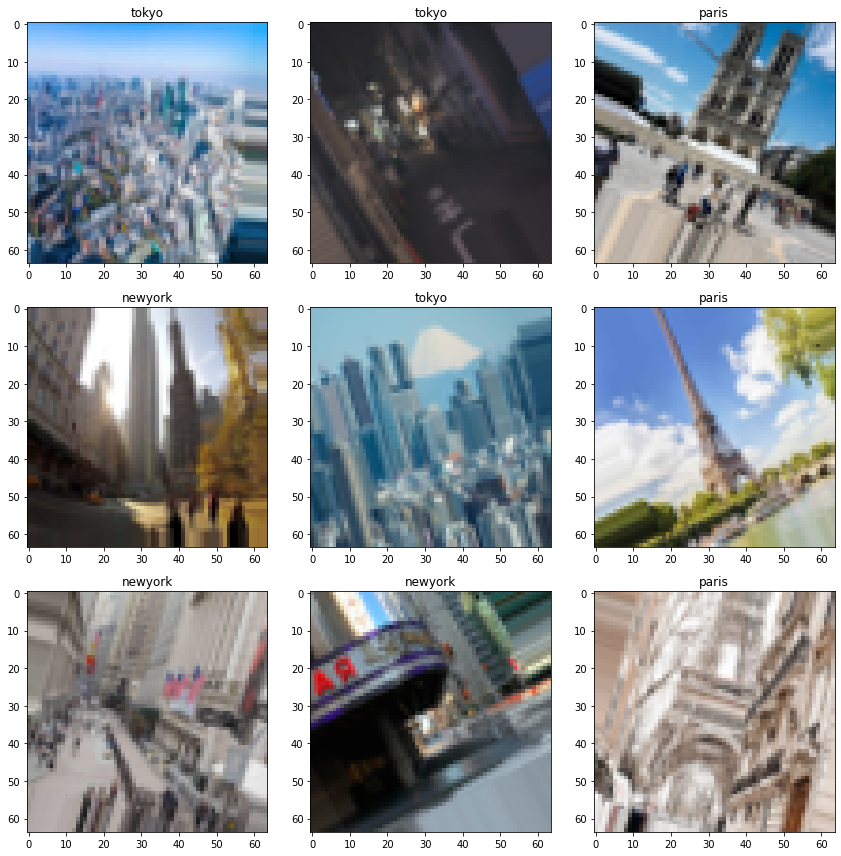

In [5]:
%matplotlib inline

generated = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
img, label = generated.next()

visualize_random_images(img, label, CLASSES)

## Modèles

### Basic Model 1

[Code source](models/basic_model_1.py)

In [6]:
# Creation du modele
model = basic_model_1(CLASSES, IMAGE_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 96)         0

In [7]:
# Entrainement du modele
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history_bm1 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
96/96 [==============================] - 4s 36ms/step - loss: 1.0810 - accuracy: 0.3973 - val_loss: 1.0827 - val_accuracy: 0.3632
Epoch 2/50
96/96 [==============================] - 3s 36ms/step - loss: 1.0329 - accuracy: 0.4665 - val_loss: 1.0977 - val_accuracy: 0.3483
Epoch 3/50
96/96 [==============================] - 3s 31ms/step - loss: 1.0160 - accuracy: 0.4895 - val_loss: 0.9910 - val_accuracy: 0.5224
Epoch 4/50
96/96 [==============================] - 3s 28ms/step - loss: 0.9968 - accuracy: 0.4885 - val_loss: 0.9753 - val_accuracy: 0.5373
Epoch 5/50
96/96 [==============================] - 3s 29ms/step - loss: 0.9584 - accuracy: 0.5252 - val_loss: 1.0691 - val_accuracy: 0.4478
Epoch 6/50
96/96 [==============================] - 2s 25ms/step - loss: 0.9374 - accuracy: 0.5472 - val_loss: 0.9712 - val_accuracy: 0.5124
Epoch 7/50
96/96 [==============================] - 2s 25ms/step - loss: 0.8890 - accuracy: 0.5755 - val_loss: 0.9987 - val_accuracy: 0.4925
Epoch 8/50
96

KeyboardInterrupt: 

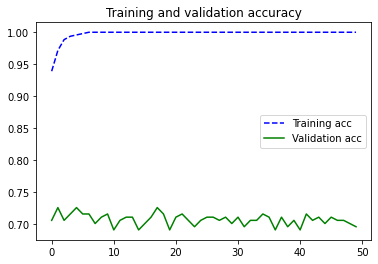

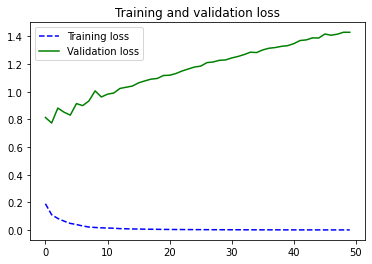

In [36]:
# Analyse des résultats
plot_training_analysis(history_bm1, 'accuracy')

### VGG-16

#### Transfer learning

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [ ]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

In [39]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dense(len(CLASSES), activation="softmax"))


model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()


history = model.fit(train_features, y_train,
                    epochs=EPOCHS,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dense_17 (Dense)            (None, 3)                 771       
                                                                 
Total params: 525,315
Trainable params: 525,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
60/60 [==============================] - 1s 6ms/step - loss: 0.9623 - accuracy: 0.5273 - val_loss: 0.8587 - val_accuracy: 0.6318
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.7303 - accuracy: 0.7065 - val_loss: 0.7749 - val_accuracy: 0.6866
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.7558 - val_loss: 0.8374 - val_accuracy: 0.6418
Epoch 4/50
60/60 [======

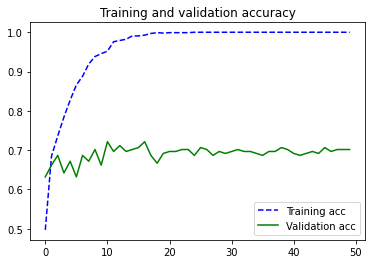

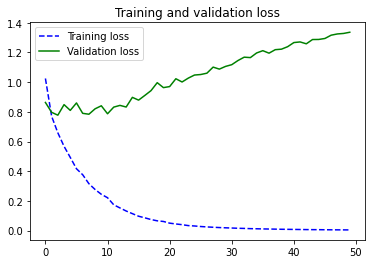

In [38]:
plot_training_analysis(history, 'accuracy')

#### Intégration de l'augmentation de données

In [45]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dense(len(CLASSES), activation="softmax"))


conv_base.trainable = False
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dense_19 (Dense)            (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 525,315
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    )

#Problème pas assez d'époque (10 -> 50) et on avait mis metrics=['accurency']

Epoch 1/50
96/96 [==============================] - 14s 138ms/step - loss: 0.9857 - sparse_categorical_accuracy: 0.5325 - val_loss: 0.9981 - val_sparse_categorical_accuracy: 0.5323
Epoch 2/50
96/96 [==============================] - 12s 125ms/step - loss: 0.8550 - sparse_categorical_accuracy: 0.6080 - val_loss: 0.8250 - val_sparse_categorical_accuracy: 0.6169
Epoch 3/50
96/96 [==============================] - 13s 134ms/step - loss: 0.7902 - sparse_categorical_accuracy: 0.6782 - val_loss: 0.8364 - val_sparse_categorical_accuracy: 0.6169
Epoch 4/50
96/96 [==============================] - 12s 123ms/step - loss: 0.7555 - sparse_categorical_accuracy: 0.6593 - val_loss: 0.7966 - val_sparse_categorical_accuracy: 0.6617
Epoch 5/50
96/96 [==============================] - 12s 128ms/step - loss: 0.7154 - sparse_categorical_accuracy: 0.6866 - val_loss: 0.8668 - val_sparse_categorical_accuracy: 0.6219
Epoch 6/50
96/96 [==============================] - 12s 126ms/step - loss: 0.6811 - sparse_cate

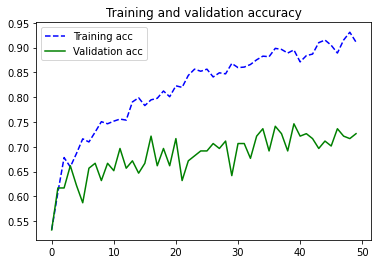

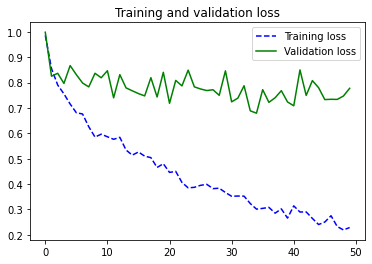

In [34]:
plot_training_analysis(history, 'sparse_categorical_accuracy')

#### Fine-tuning

In [46]:
conv_base.trainable = True
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dense_19 (Dense)            (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 15,240,003
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    )

Epoch 1/50
96/96 [==============================] - 55s 561ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.3459 - val_loss: 1.1003 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/50
96/96 [==============================] - 54s 565ms/step - loss: 1.1082 - sparse_categorical_accuracy: 0.3470 - val_loss: 1.0879 - val_sparse_categorical_accuracy: 0.3632
Epoch 3/50
96/96 [==============================] - 54s 564ms/step - loss: 1.0824 - sparse_categorical_accuracy: 0.4057 - val_loss: 1.0157 - val_sparse_categorical_accuracy: 0.5274
Epoch 4/50
96/96 [==============================] - 55s 569ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.4015 - val_loss: 1.0175 - val_sparse_categorical_accuracy: 0.5124
Epoch 5/50
96/96 [==============================] - 56s 582ms/step - loss: 1.0723 - sparse_categorical_accuracy: 0.4182 - val_loss: 1.0564 - val_sparse_categorical_accuracy: 0.4876
Epoch 6/50
96/96 [==============================] - 57s 595ms/step - loss: 1.0705 - sparse_cate

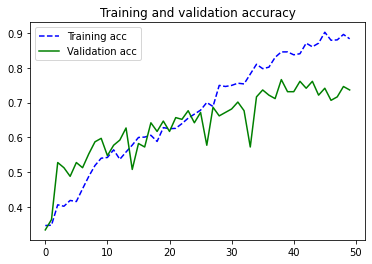

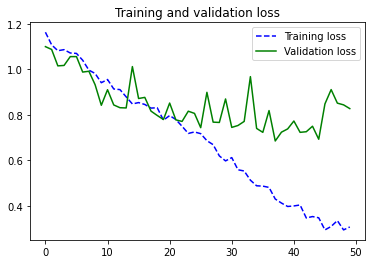

In [48]:
plot_training_analysis(history, 'sparse_categorical_accuracy')

## Analyse

Matrice de confusion
NY :   TP: 34  FN: 33  FP: 30
Paris :   TP: 31  FN: 30  FP: 23
Tokyo :   TP: 57  FN: 16  FP: 26
La précision globale est de 0.6%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| NY     |   0.53    |  0.51  |   0.52   |
------------------------------------------
| Paris  |   0.57    |  0.51  |   0.54   |
------------------------------------------
| Tokyo  |   0.69    |  0.78  |   0.73   |
------------------------------------------


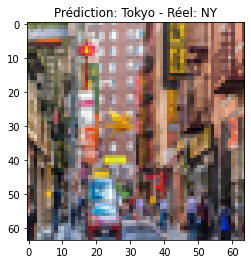

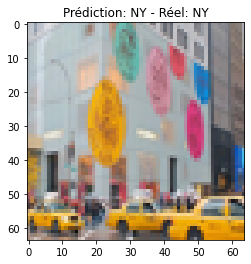

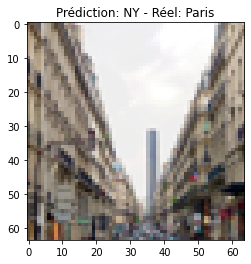

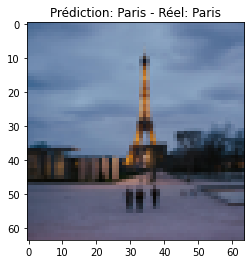

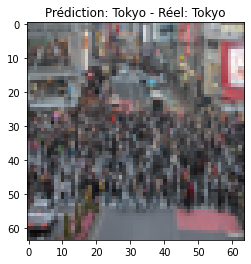

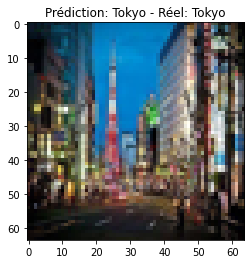

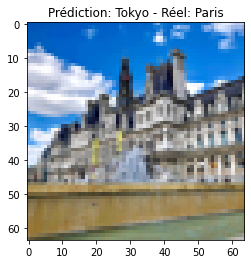

In [47]:
show_analye(x_test, y_test)